In [1]:
import os
import numpy as np
from PIL import Image, ImageFile
from skimage import io
import matplotlib.pyplot as plt
import tifffile
from scipy import misc
from tifffile import TiffFile
from tifffile.tifffile import TIFF_DECOMPESSORS
from visualization import ids_to_greyscale, load_depth, show_bounding_boxes, load_stencil_ids, load_stencil_flags, \
get_bounding_boxes, show_loaded_bounding_boxes

In [44]:
import visualization
visualization.multi_page = False
visualization.ini_file = 'gta-postprocessing.local.ini'

scene_condition = """
    ( \
        SELECT scene_id \
        FROM snapshots \
        WHERE run_id = 6 \
        ORDER BY timestamp DESC \
        OFFSET 80 \
        LIMIT 1 \
    ) \
    """

scene_condition = """
    'cb74a5f3-470e-4e83-8b55-b56eca795dad' \
    """

conn = visualization.get_connection()
cur = conn.cursor()
cur.execute("""SELECT snapshot_id, imagepath, cam_near_clip, cam_far_clip, timestamp, view_matrix, proj_matrix,
    ARRAY[st_x(camera_relative_rotation), st_y(camera_relative_rotation), st_z(camera_relative_rotation)] as relative_cam_rot \
    FROM snapshots \
    WHERE scene_id = {} \
    ORDER BY snapshot_id ASC \
    """.format(scene_condition))

results = [dict(res) for res in cur]
names = [i['imagepath'] for i in results]
print(names[0])

2018-02-20--22-20-33--363


### obtaining detections for this scene

In [3]:
detections = {}
for res in results:
    cur.execute("""SELECT detection_id, type, class, bbox, \
        snapshot_id, handle, ARRAY[st_x(pos), st_y(pos), st_z(pos)] AS pos \
        FROM detections \
        WHERE snapshot_id = {} \
        AND type = 'car' \
        AND NOT bbox @> point '(Infinity, Infinity)' \
        """.format(res['snapshot_id']))
    detections[res['snapshot_id']] = [dict(i) for i in cur]


In [4]:
for res in results:  
    print('detections for image {}:'.format(res['snapshot_id']))
    for det in detections[res['snapshot_id']]:
        print(det)

detections for image 6181:
{'class': 'Sports', 'handle': 32770, 'bbox': '(0.970924079418182,0.332836776971817),(0.7982337474823,0.203327819705009)', 'snapshot_id': 6181, 'type': 'car', 'detection_id': 1012555, 'pos': [-915.460266113281, -165.864135742188, 41.4971542358398]}
{'class': 'Sedans', 'handle': 33538, 'bbox': '(0.844984769821167,0.749781250953674),(0.38293319940567,0.438985764980316)', 'snapshot_id': 6181, 'type': 'car', 'detection_id': 1012559, 'pos': [-921.231750488281, -180.163208007812, 37.0985260009766]}
{'class': 'SUVs', 'handle': 53762, 'bbox': '(0.515567600727081,0.440443515777588),(0.509682476520538,0.433965593576431)', 'snapshot_id': 6181, 'type': 'car', 'detection_id': 1012561, 'pos': [-1023.27575683594, 94.9759521484375, 51.5883102416992]}
{'class': 'Commercial', 'handle': 250114, 'bbox': '(0.409929305315018,0.519451558589935),(0.278179615736008,0.410455942153931)', 'snapshot_id': 6181, 'type': 'car', 'detection_id': 1012566, 'pos': [-942.769714355469, -155.0114746

### showing rgb images

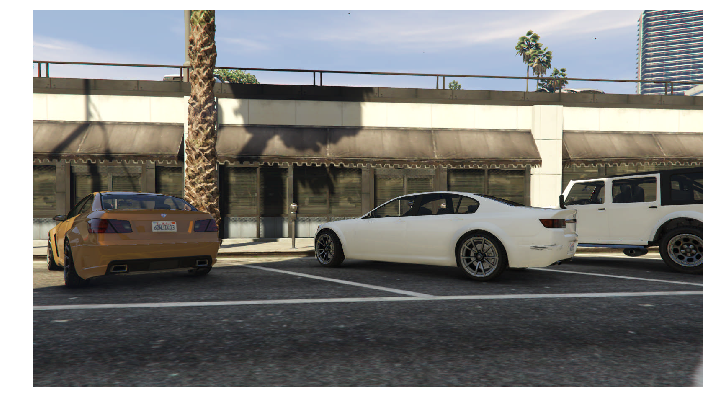

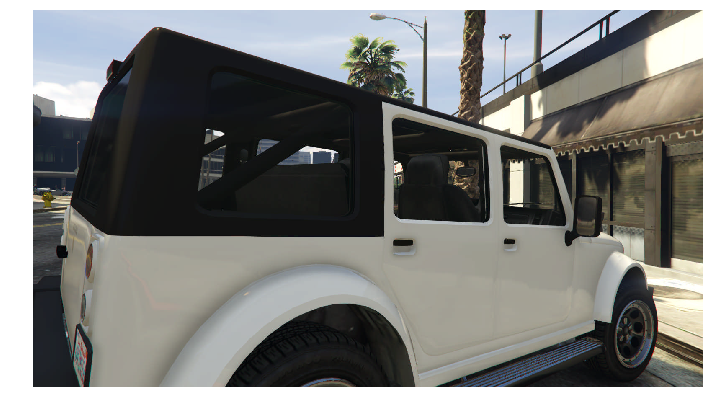

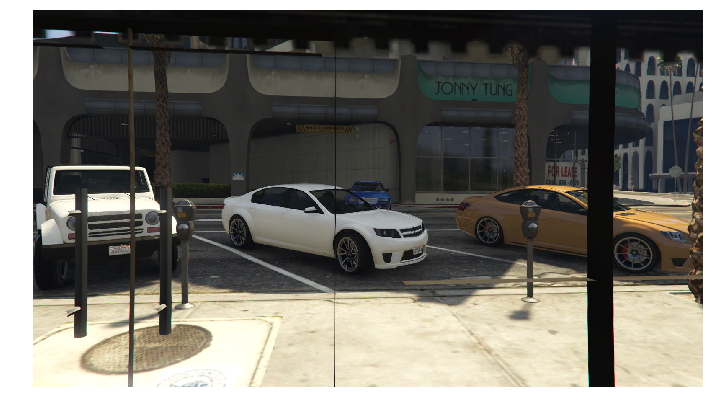

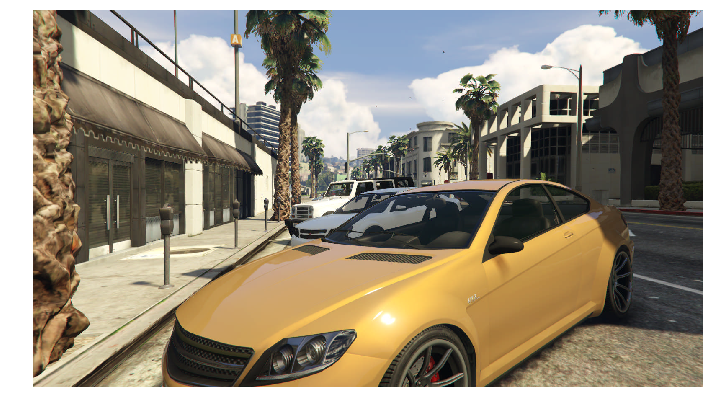

In [5]:
for name in names:
    im = Image.open(os.path.join(visualization.get_in_directory(), name + '.tiff'))
    fig = plt.figure(figsize=(12,12))
    plt.axis('off')
    plt.imshow(im)
    plt.show()

### showing depths

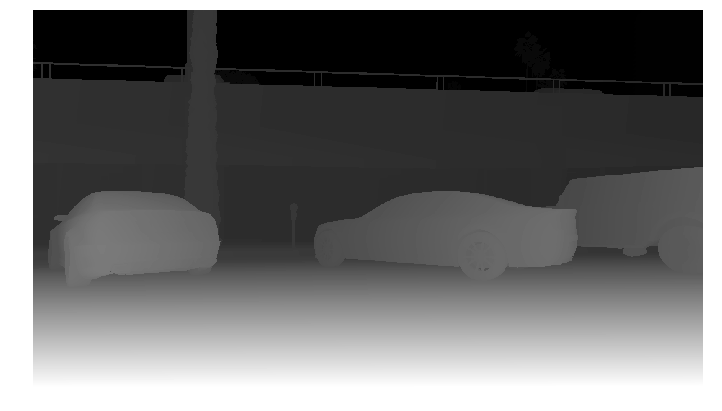

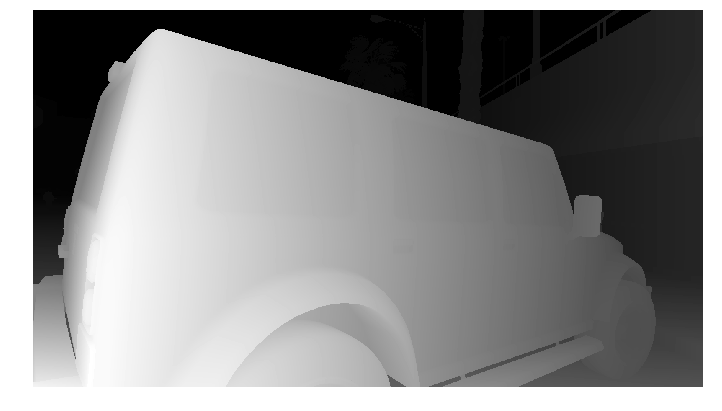

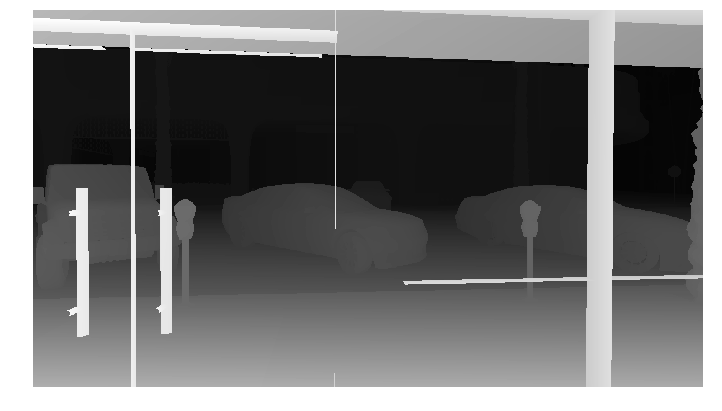

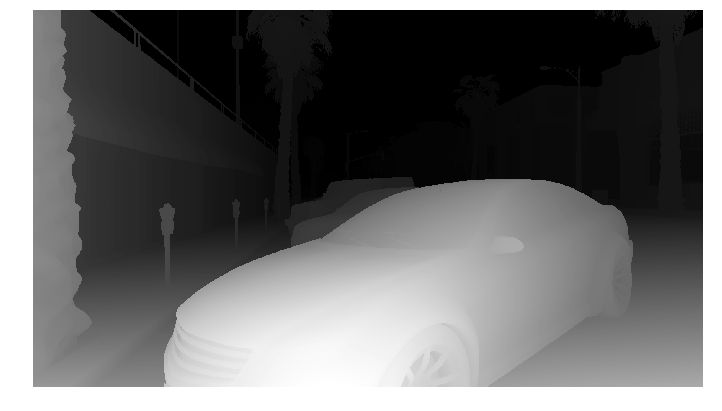

In [6]:
for name in names:
    depth = load_depth(name)
    fig = plt.figure(figsize=(12,12))
    plt.axis('off')
    plt.imshow(depth, cmap='gray')
    plt.show()


### showing stencil ids

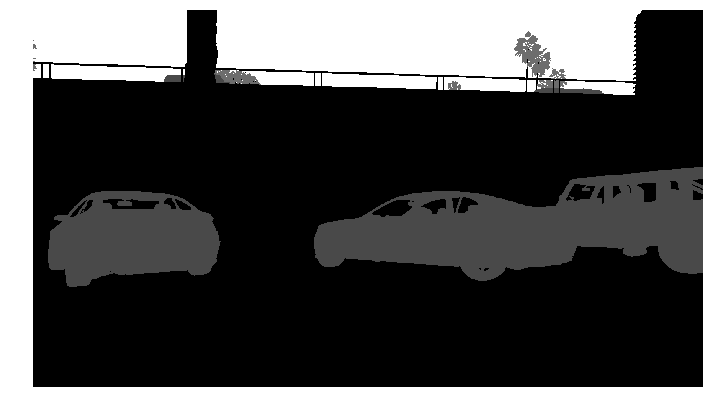

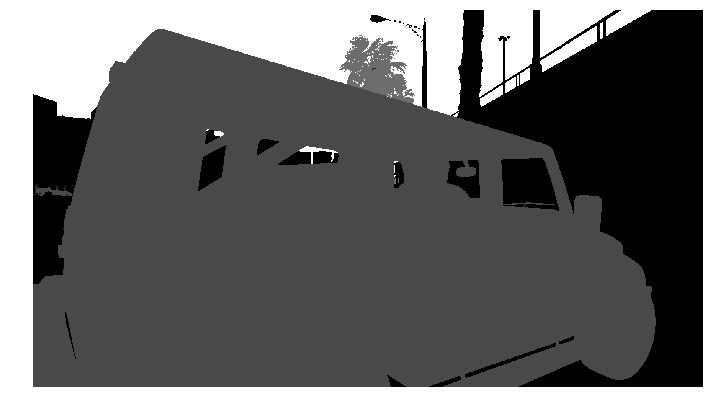

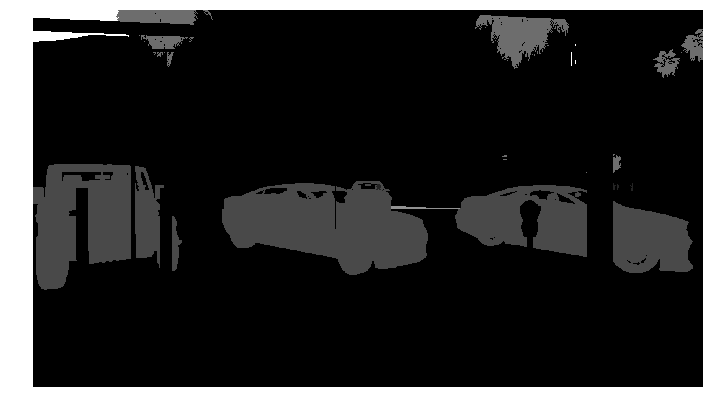

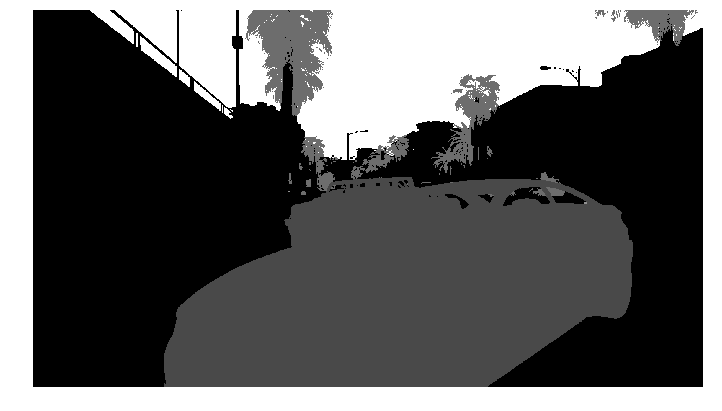

In [7]:
for name in names:
    depth = load_stencil_ids(name)
    fig = plt.figure(figsize=(12,12))
    plt.axis('off')
    plt.imshow(depth, cmap='gray')
    plt.show()


### tinkering with depth, showing its values

Depth is in NDC, openGL's Normalized Device Coordinates. 

According to [this thread](https://www.opengl.org/discussion_boards/showthread.php/170718-Normalized-Device-Coordinates) 
it maps from $[near clip (n_c), far clip(f_c)]$ to $[-1, 1]$.

So the formula for calculating NDC from world coordinates (WC) is simple linear transformation:

$ NDC = k \cdot WC + q $

$ -1 = k \cdot n_c + q $

$ 1 = k \cdot f_c + q $

After solving these equations, we obtain transformation parameters

$ q = -1 - k \cdot n_c $

$ q = 1 - k \cdot f_c $

$ -1 - k \cdot n_c = 1 - k \cdot f_c $

$ - k \cdot n_c = 2 - k \cdot f_c $

$ -2 = k (n_c - f_c) $

$ k = \frac{-2}{n_c - f_c} $

$ q = 1 - k \cdot f_c $

$ q = 1 - \frac{-2}{n_c - f_c} \cdot f_c $

$ q = 1 + \frac{2 f_c}{n_c - f_c} $

So the resulting linear transformations is as follows

$ NDC = \frac{-2}{n_c - f_c} \cdot WC + \frac{2 f_c}{n_c - f_c} $

And the reverse transformation, from NDC back to WC, shall be obtained by the same approach

$ WC = k \cdot NDC + q $

$ n_c = k \cdot -1 + q $

$ f_c = k \cdot 1 + q $

$ n_c = -k + q $

$ f_c = k + q $

After solving these equations, we obtain transformation parameters

$ q = n_c + k $

$ q = f_c - k $

$ n_c + k = f_c - k $

$ n_c + 2k = f_c $

$ k = \frac{f_c - n_c}{2} $

$ q = f_c - k $

$ q = f_c - \frac{f_c - n_c}{2} $

$ q = f_c + \frac{-f_c + n_c}{2} $

$ q = \frac{f_c + n_c}{2} $

And resulting transformation is

$ WC = \frac{f_c - n_c}{2} \cdot NDC + \frac{f_c + n_c}{2} $



For mapping from and to $[0, 1]$

So the formula for calculating NDC from world coordinates (WC) is simple linear transformation:

$ NDC = k \cdot WC + q $

$ 0 = k \cdot n_c + q $

$ 1 = k \cdot f_c + q $

After solving these equations, we obtain transformation parameters

$ q = 0 - k \cdot n_c $

$ q = 1 - k \cdot f_c $

$ 0 - k \cdot n_c = 1 - k \cdot f_c $

$ - k \cdot n_c = 1 - k \cdot f_c $

$ -1 = k (n_c - f_c) $

$ k = \frac{-1}{n_c - f_c} $

$ q = - k \cdot f_c $

$ q = - \frac{-1}{n_c - f_c} \cdot f_c $

$ q = \frac{f_c}{n_c - f_c} $

So the resulting linear transformations is as follows

$ NDC = \frac{-1}{n_c - f_c} \cdot WC + \frac{f_c}{n_c - f_c} $

And the reverse transformation, from NDC back to WC, shall be obtained by the same approach

$ WC = k \cdot NDC + q $

$ n_c = k \cdot 0 + q $

$ f_c = k \cdot 1 + q $

$ n_c = q $

$ f_c = k + q $

After solving these equations, we obtain transformation parameters

$ q = n_c $

$ q = f_c - k $

$ n_c = f_c - k $

$ n_c + k = f_c $

$ k = f_c - n_c $

$ q = f_c - k $

$ q = f_c - (f_c - n_c) $

$ q = n_c $

And resulting transformation is

$ WC = (f_c - n_c) \cdot NDC + n_c $


In [8]:
for res in results:    
    name = res['imagepath']
    depth = load_depth(name)
    near_clip = res['cam_near_clip']
    far_clip = res['cam_far_clip']
    print('camera rot: {}'.format(res['relative_cam_rot']))
    print('image name: {}'.format(res['imagepath']))
    print('created: {}'.format(res['timestamp']))
    print('depth min: {}'.format(np.min(depth)))
    print('depth max: {}'.format(np.max(depth)))
    print('near clip: {}'.format(near_clip))
    print('far clip: {}'.format(far_clip))
    
    k = (far_clip - near_clip) / 2
    q = (far_clip + near_clip) / 2
    new_depth = depth * k + q
    print('new depth min: {}'.format(np.min(new_depth)))
    print('new depth max: {}'.format(np.max(new_depth)))
    
    # fig = plt.figure(figsize=(12,12))
    # plt.axis('off')
    # plt.imshow(new_depth, cmap='gray')
    # plt.show()


camera rot: [0.0, 0.0, 0.0]
image name: 2018-02-20--22-20-33--363
created: 2018-02-20 22:20:33.363100+00:00
depth min: 0.0
depth max: 0.06304038316011429
near clip: 0.15
far clip: 800.0
new depth min: 400.07501220703125
new depth max: 425.28643798828125
camera rot: [0.0, 0.0, 90.0]
image name: 2018-02-20--22-20-34--353
created: 2018-02-20 22:20:34.353387+00:00
depth min: 0.0
depth max: 0.1431778520345688
near clip: 0.15
far clip: 800.0
new depth min: 400.07501220703125
new depth max: 457.3354187011719
camera rot: [0.0, 0.0, 180.0]
image name: 2018-02-20--22-20-35--485
created: 2018-02-20 22:20:35.485992+00:00
depth min: 0.0
depth max: 0.07723810523748398
near clip: 0.15
far clip: 800.0
new depth min: 400.07501220703125
new depth max: 430.9644470214844
camera rot: [0.0, 0.0, 270.0]
image name: 2018-02-20--22-20-36--620
created: 2018-02-20 22:20:36.620969+00:00
depth min: 0.0
depth max: 0.08818064630031586
near clip: 0.15
far clip: 800.0
new depth min: 400.07501220703125
new depth max: 4

### showing bounding boxes

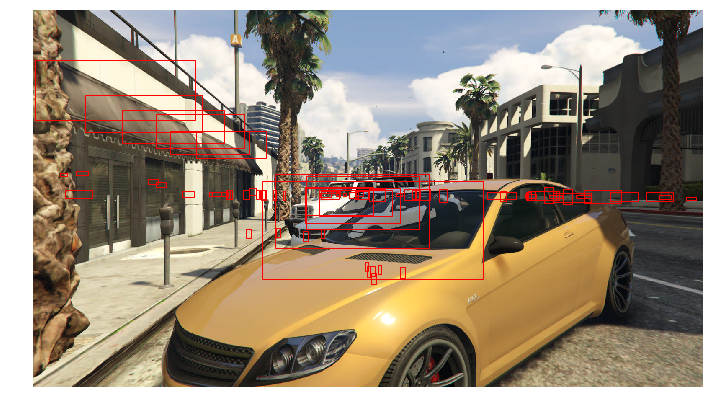

In [9]:
name = names[3]
im = Image.open(os.path.join(visualization.get_in_directory(), name + '.tiff'))
fig = plt.figure(figsize=(12,12))
plt.axis('off')
plt.imshow(im)
size = (im.size[1], im.size[0])
show_bounding_boxes(name, size, plt.gca())


### showing bounding boxes for all cameras

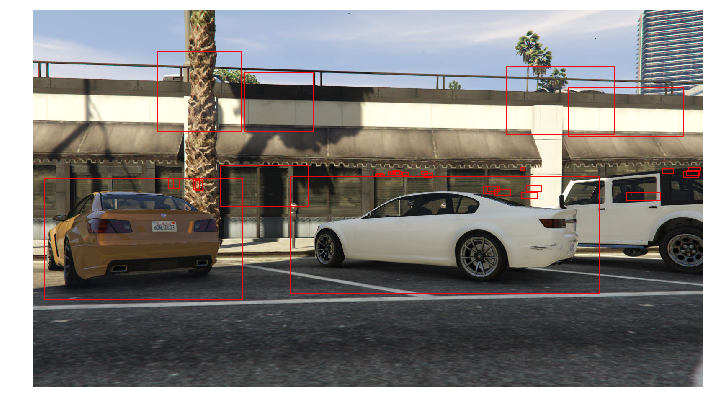

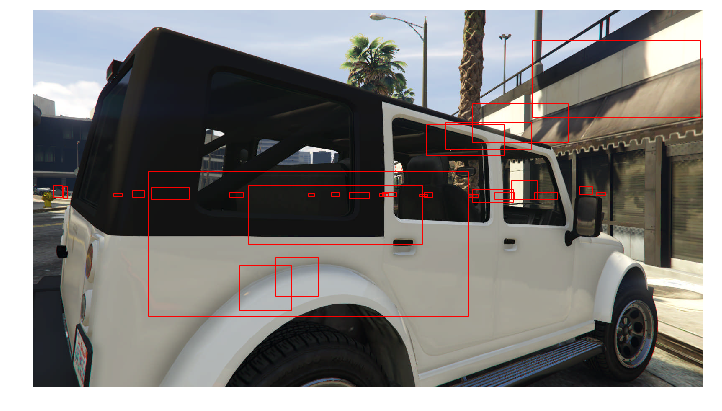

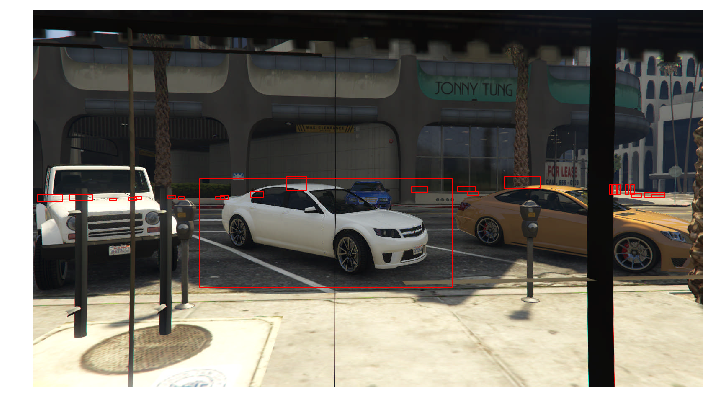

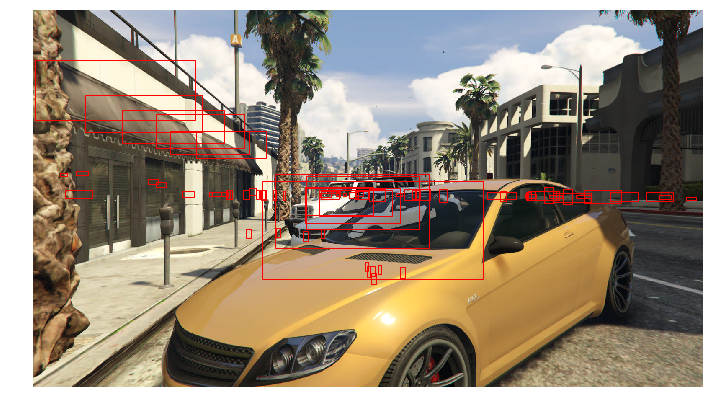

In [10]:
for name in names:
    im = Image.open(os.path.join(visualization.get_in_directory(), name + '.tiff'))
    fig = plt.figure(figsize=(12,12))
    plt.axis('off')
    plt.imshow(im)
    size = (im.size[1], im.size[0])
    show_bounding_boxes(name, size, plt.gca())


### playing with depth and bounding boxes

detections before filtering: 74
detections after filtering: 3


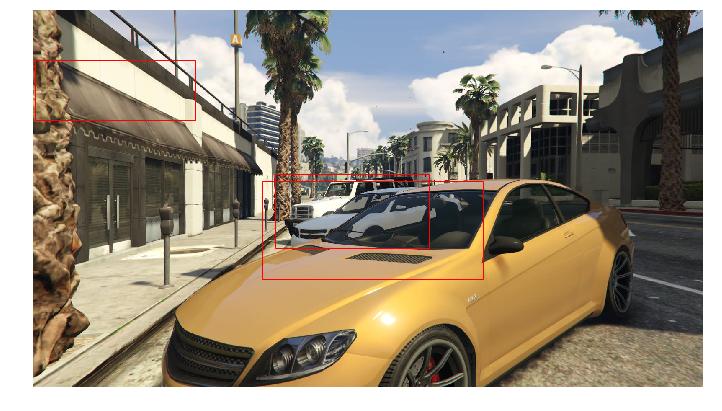

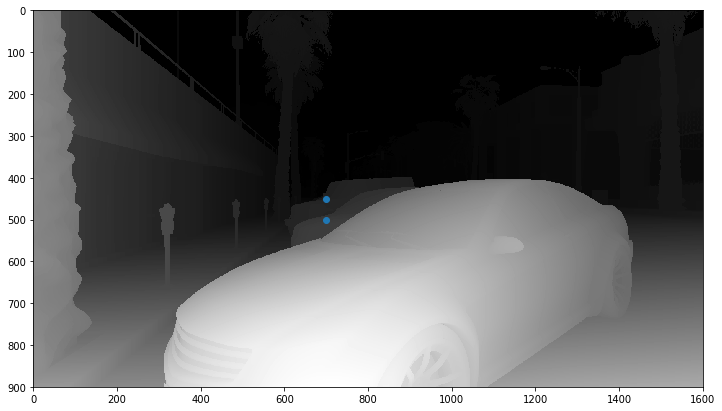

In [39]:
name = names[3]
im = Image.open(os.path.join(visualization.get_in_directory(), name + '.tiff'))
fig = plt.figure(figsize=(12,12))
plt.axis('off')
plt.imshow(im)
size = (im.size[1], im.size[0])
detections = get_bounding_boxes(name)
print('detections before filtering: ' + str(len(detections)))
# sizes = [str(d['bbox'][0, 0] - d['bbox'][1, 0]) for d in detections]
# print('sizes: '+', '.join(sizes))
detections = [d for d in detections if (d['bbox'][0, 0] - d['bbox'][1, 0]) > 0.2]
show_loaded_bounding_boxes(detections, size, plt.gca())
print('detections after filtering: ' + str(len(detections)))

depth = load_depth(name)
fig = plt.figure(figsize=(12,12))
plt.axis('on')
# plt.gca().grid(color='r', linestyle='-', linewidth=1)
plt.plot([700, 700], [450, 500], 'o')
plt.imshow(depth, cmap='gray')
plt.show()

In [40]:
print('columns: '+', '.join(detections[0].keys()))
for det in detections:
    bbox = det['bbox']
    print(bbox)
    print(det['bbox'][0, 0] - det['bbox'][1, 0])
    print(det['pos'])
    
car_0 = detections[0]
car_1 = detections[1]

print('car_0 pos: '+ str(car_0['pos']))
print('car_1 pos: '+ str(car_1['pos']))
print('cars distance: '+ str(np.linalg.norm(np.array(car_0['pos'][0:2]) - np.array(car_1['pos'][0:2]))))


columns: proj_matrix, bbox, view_matrix, pos, bbox3d
[[ 0.67154467  0.71382439]
 [ 0.34189156  0.45318154]]
0.32965311408
[-921.231750488281, -180.163208007812, 37.0985260009766]
[[ 0.59029388  0.6305477 ]
 [ 0.36047614  0.43463627]]
0.22981774807
[-917.710144042969, -178.007690429688, 36.8862800598145]
[[ 0.24147792  0.29006985]
 [ 0.00298757  0.13057077]]
0.23849034775
[-918.227966308594, -168.178985595703, 41.5112686157227]
car_0 pos: [-921.231750488281, -180.163208007812, 37.0985260009766]
car_1 pos: [-917.710144042969, -178.007690429688, 36.8862800598145]
cars distance: 4.12891850068
raw depth distance: 0.0024794


In [64]:
print('raw point 1: {}'.format(depth[500, 700]))
print('raw point 2: {}'.format(depth[450, 700]))
print('raw point 1: {}'.format(depth[700, 500]))
print('raw point 2: {}'.format(depth[700, 450]))
print('raw depth distance: '+ str(depth[500, 700] - depth[450, 700]))

k = (far_clip - near_clip) / 2
q = (far_clip + near_clip) / 2
new_depth = depth * k + q
print('-1,1 depth distance: {}'.format(new_depth[700, 500] - new_depth[700, 450]))

k = far_clip - near_clip
q = near_clip
new_depth = depth * k + q
print('0, 1 point 1: {}'.format(new_depth[500, 700]))
print('0, 1 point 2: {}'.format(new_depth[450, 700]))
print('0, 1 depth distance: {}'.format(new_depth[700, 500] - new_depth[700, 450]))

c = 1
new_depth = (np.exp(depth * np.log(far_clip * c + 1)) - 1)/c
print('exp depth distance: {}'.format(new_depth[700, 500] - new_depth[700, 450]))
new_depth = 1 / new_depth
print('exp invered point 1: {}'.format(new_depth[500, 700]))
print('exp invered point 2: {}'.format(new_depth[450, 700]))
print('exp invered depth distance: {}'.format(new_depth[700, 500] - new_depth[700, 450]))

res = results[3]
print('keys: '+', '.join(res.keys()))
print('view matrix:')
print(np.array(res['view_matrix']))
print('proj matrix:')
print(np.array(res['proj_matrix']))


raw point 1: 0.019676903262734413
raw point 2: 0.011593842878937721
raw point 1: 0.06877238303422928
raw point 2: 0.06629298627376556
raw depth distance: 0.00808306
-1,1 depth distance: 0.9915771484375
0, 1 point 1: 15.888569831848145
0, 1 point 2: 9.423334121704102
0, 1 depth distance: 1.9831428527832031
exp depth distance: 0.02603745460510254
exp invered point 1: 7.112226486206055
exp invered point 2: 12.407219886779785
exp invered depth distance: -0.07997310161590576
keys: timestamp, imagepath, view_matrix, relative_cam_rot, snapshot_id, cam_near_clip, cam_far_clip, proj_matrix
view matrix:
[[  3.64584816e-01  -9.31166945e-01   2.44093372e-03   1.68375065e+02]
 [  9.48954039e-03   6.33669622e-03   9.99934866e-01  -2.77074237e+01]
 [ -9.31121771e-01  -3.64537835e-01   1.11466121e-02  -9.32850155e+02]
 [  0.00000000e+00   0.00000000e+00   0.00000000e+00   1.00000000e+00]]
proj matrix:
[[  1.20628517e+00  -1.92500180e-09  -1.61737867e-08  -1.84581918e-07]
 [ -1.08251232e-09   2.1445069

c:\users\azathoth\appdata\local\programs\python\python35\lib\site-packages\ipykernel_launcher.py:22: RuntimeWarning: divide by zero encountered in true_divide


In [48]:
depth[899, 800]

0.086945087

In [49]:
depth[100, 1400]

0.0

In [62]:
print(np.min(depth))
print(np.max(depth))

0.0
0.0881806


In [67]:
print(np.min(new_depth))
print(np.max(new_depth))
print(depth.shape)

1.24502
inf
(900, 1600)


In [68]:
 vec = (700/depth.shape[1], 500/depth.shape[0], depth[500, 700])

(0.4375, 0.5555555555555556, 0.019676903)

In [69]:
submatrix = np.array(res['view_matrix'])[0:3, 0:3]
print(submatrix)
np.linalg.det(submatrix)

[[ 0.36458482 -0.93116695  0.00244093]
 [ 0.00948954  0.0063367   0.99993487]
 [-0.93112177 -0.36453784  0.01114661]]


0.99999985004382563

In [124]:
proj_matrix = np.array(res['proj_matrix'])
vec = np.linalg.inv(proj_matrix) @ np.array([[1], [1], [0.0001], [1]])
print(vec / vec[3])
print(res['cam_near_clip'])
print(res['cam_far_clip'])
print('proj_matrix')

print(proj_matrix)
print('inverted proj_matrix')
print(np.linalg.inv(proj_matrix))

el1 = (- far_clip - near_clip)/(2*(near_clip*far_clip))
el2 = (far_clip + near_clip)/(2*(near_clip*far_clip))
print(el1)
print(el2)

matrix = np.zeros((4, 4))
matrix[2, 3] = -1
matrix[3, 2] = el1
matrix[3, 3] = el2
print(matrix)
vec = matrix @ np.array([[1], [1], [0], [1]])
print(vec / vec[3])
print(proj_matrix[0,0])
print(1/ np.linalg.inv(proj_matrix)[0,0])


[[  1.08111788e+03]
 [  6.08128829e+02]
 [ -1.30413649e+03]
 [  1.00000000e+00]]
0.15
800.0
proj_matrix
[[  1.20628517e+00  -1.92500180e-09  -1.61737867e-08  -1.84581918e-07]
 [ -1.08251232e-09   2.14450693e+00  -3.33965397e-09  -4.50933544e-07]
 [ -1.07213684e-13   4.77908242e-15   1.50203702e-05   1.50002262e-01]
 [ -1.27122705e-16   8.23993651e-18  -1.00000000e+00  -2.84217094e-14]]
inverted proj_matrix
[[  8.28991374e-01   7.44138371e-10   1.02009674e-06  -1.33926075e-08]
 [  4.18461401e-10   4.66307657e-01   1.40180396e-06  -1.53625061e-09]
 [ -1.05383626e-16   3.84234539e-18  -1.89475206e-13  -1.00000000e+00]
 [  5.92519204e-13  -1.48565940e-14   6.66656615e+00   1.00134291e-04]]
-3.3339583333333334
3.3339583333333334
[[ 0.          0.          0.          0.        ]
 [ 0.          0.          0.          0.        ]
 [ 0.          0.          0.         -1.        ]
 [ 0.          0.         -3.33395833  3.33395833]]
[[ 0.        ]
 [ 0.        ]
 [-0.29994376]
 [ 1.        ]]


In [94]:
vec = np.array([1, 1, 1, 1]) @ np.linalg.inv(np.array(res['proj_matrix']))
vec / vec[3]
# todo: zkusit near clip 1.5 třeba
# todo: tahat model dimensions pro auta
# todo: tahat model matrix

array([-0.82907438, -0.46635435, -6.66723609,  1.        ])